In [17]:
import pandas as pd
import numpy as np

# For splitting data
from sklearn.model_selection import train_test_split
# For handling class imbalance
from sklearn.utils import class_weight
# For data preprocessing
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt


In [18]:
# 1. Load the Dataset
df = pd.read_csv("D:\\MapApp\\Churn_Modelling.csv")

# 2. Drop Irrelevant Columns
df.drop(columns=["RowNumber", "CustomerId", "Surname"], inplace=True)

# 3. Separate Features (X) and Target (y)
X = df.drop("Exited", axis=1)
y = df["Exited"]


In [19]:
categorical_cols = ["Geography", "Gender"]
numerical_cols = [col for col in X.columns if col not in categorical_cols]


In [20]:
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numerical_cols),
    ("cat", OneHotEncoder(drop="first"), categorical_cols)
])

X_transformed = preprocessor.fit_transform(X)
print("Shape after encoding & scaling:", X_transformed.shape)


Shape after encoding & scaling: (10000, 11)


In [21]:
n_samples = X_transformed.shape[0]
n_features = X_transformed.shape[1]

# LSTM expects (samples, timesteps, features)
X_reshaped = X_transformed.reshape((n_samples, 1, n_features))
print("Shape after reshaping for LSTM:", X_reshaped.shape)


Shape after reshaping for LSTM: (10000, 1, 11)


In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    X_reshaped, y, test_size=0.2, random_state=42
)


In [23]:
# Identify unique classes (0 = stayed, 1 = churned)
unique_classes = np.unique(y_train)

# Compute balanced weights automatically
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=unique_classes,
    y=y_train
)

class_weights_dict = dict(zip(unique_classes, weights))
print("Computed class weights:", class_weights_dict)


Computed class weights: {0: 0.6293266205160478, 1: 2.4330900243309004}


In [24]:
model = Sequential([
    LSTM(64, input_shape=(1, n_features), activation='relu'),
    Dropout(0.3),  # Helps reduce overfitting
    Dense(1, activation='sigmoid')  # Binary classification output
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        Precision(name='precision'),
        Recall(name='recall')
    ]
)

model.summary()


C:\Users\chand\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 64)             │        19,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,521 (76.25 KB)

 Trainable params: 19,521 (76.25 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)


In [26]:
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

history = model.fit(
    X_train, y_train,
    epochs=35,
    batch_size=32,
    validation_data=(X_test, y_test),
    class_weight=class_weights_dict,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/35
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6226 - loss: 0.6655 - precision: 0.3258 - recall: 0.7358 - val_accuracy: 0.7345 - val_loss: 0.5618 - val_precision: 0.4044 - val_recall: 0.7430
Epoch 2/35
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7277 - loss: 0.5430 - precision: 0.4025 - recall: 0.7264 - val_accuracy: 0.7510 - val_loss: 0.5267 - val_precision: 0.4270 - val_recall: 0.7812
Epoch 3/35
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7435 - loss: 0.5150 - precision: 0.4214 - recall: 0.7434 - val_accuracy: 0.7510 - val_loss: 0.5117 - val_precision: 0.4278 - val_recall: 0.7913
Epoch 4/35
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7541 - loss: 0.4944 - precision: 0.4460 - recall: 0.7744 - val_accuracy: 0.7690 - val_loss: 0.4901 - val_precision: 0.4496 - val_recall: 0.7837
Epoch 5/35
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7618 - loss: 0.5001 - precision: 0.4616 - recall: 0.7704 - val_accuracy: 0.7830 - val_loss: 0.

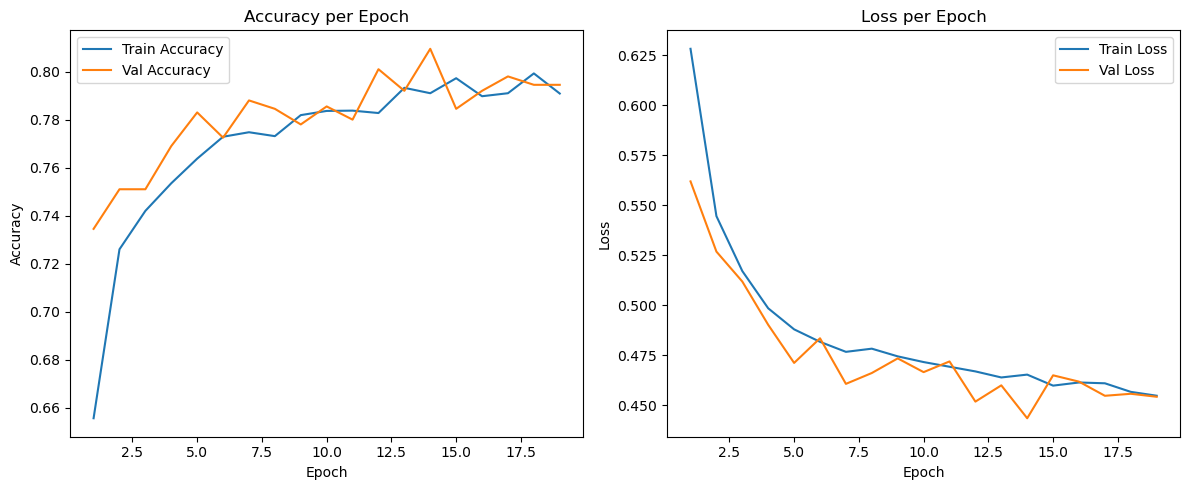

In [27]:
import matplotlib.pyplot as plt

# 1. Extract metrics from history
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# 2. Create an epoch range
epochs = range(1, len(train_acc) + 1)

# 3. Plot Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, label='Train Accuracy')
plt.plot(epochs, val_acc, label='Val Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# 4. Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Val Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [33]:
loss, accuracy, precision, recall = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss      : {loss:.4f}")
print(f"final Test Accuracy  : {accuracy:.4f}")
print(f"Test Precision : {precision:.4f}")
print(f"Test Recall    : {recall:.4f}")
print(f"Test F1 Score  : {2 * (precision * recall) / (precision + recall):.4f}")


Test Loss      : 0.4434
final Test Accuracy  : 0.8095
Test Precision : 0.5106
Test Recall    : 0.7354
Test F1 Score  : 0.6027


In [34]:
train_precision = history.history['precision']
train_recall = history.history['recall']
train_accuracy = history.history['accuracy']


val_precision = history.history['val_precision']
val_recall = history.history['val_recall']
val_accuracy = history.history['val_accuracy']


def compute_f1(precisions, recalls):
    f1_scores = []
    for p, r in zip(precisions, recalls):
        if (p + r) == 0:
            f1_scores.append(0)
        else:
            f1_scores.append(2 * p * r / (p + r))
    return f1_scores

train_f1 = compute_f1(train_precision, train_recall)
val_f1 = compute_f1(val_precision, val_recall)


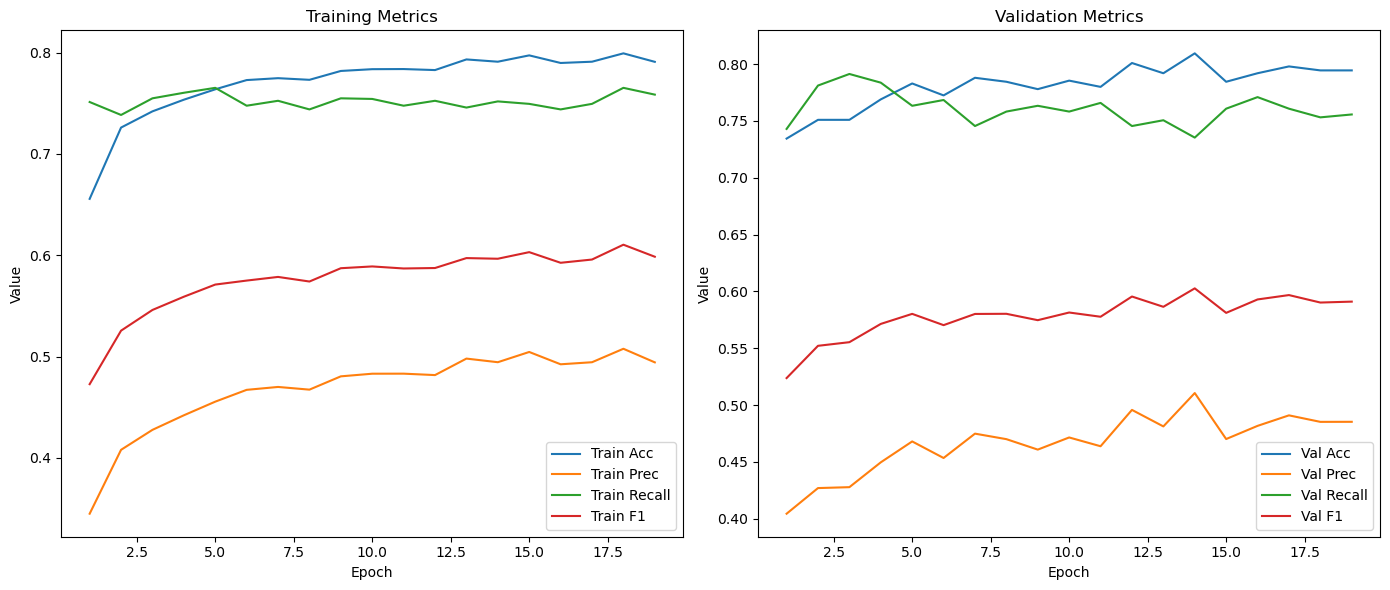

In [35]:
epochs = range(1, len(train_accuracy) + 1)

plt.figure(figsize=(14, 6))

# --- Training Metrics ---
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy, label='Train Acc')
plt.plot(epochs, train_precision, label='Train Prec')
plt.plot(epochs, train_recall, label='Train Recall')
plt.plot(epochs, train_f1, label='Train F1')
plt.title('Training Metrics')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()

# --- Validation Metrics ---
plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracy, label='Val Acc')
plt.plot(epochs, val_precision, label='Val Prec')
plt.plot(epochs, val_recall, label='Val Recall')
plt.plot(epochs, val_f1, label='Val F1')
plt.title('Validation Metrics')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()

plt.tight_layout()
plt.show()


In [36]:
# Final epoch values (or best epoch if you track that separately)
final_train_acc = train_accuracy[-1]
final_train_prec = train_precision[-1]
final_train_rec = train_recall[-1]
final_train_f1 = train_f1[-1]


final_val_acc = val_accuracy[-1]
final_val_prec = val_precision[-1]
final_val_rec = val_recall[-1]
final_val_f1 = val_f1[-1]


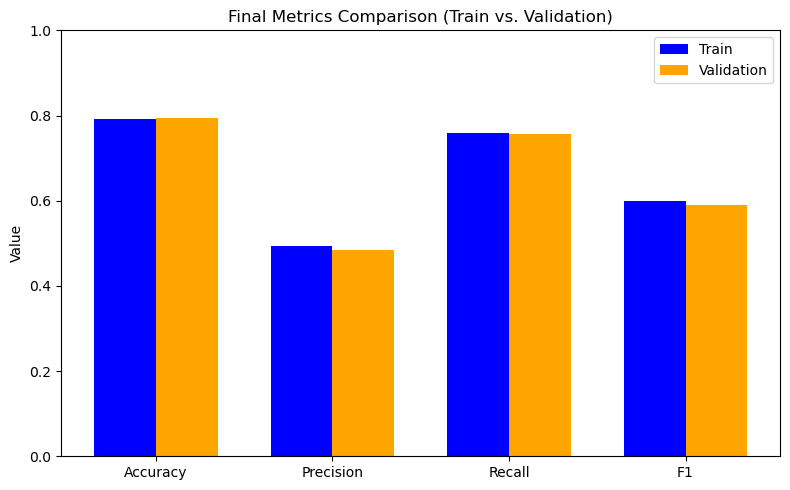

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# 2.1. Define the metric names and values
metrics = ["Accuracy", "Precision", "Recall", "F1"]
train_values = [final_train_acc, final_train_prec, final_train_rec, final_train_f1]
val_values   = [final_val_acc,   final_val_prec,   final_val_rec,   final_val_f1]

# 2.2. Create positions on the X-axis
x = np.arange(len(metrics))  # [0, 1, 2, 3, 4]
width = 0.35                 # Width of each bar

# 2.3. Plot the bars
plt.figure(figsize=(8, 5))

# Training bars (shifted left by width/2)
plt.bar(x - width/2, train_values, width, label='Train', color='blue')

# Validation bars (shifted right by width/2)
plt.bar(x + width/2, val_values,   width, label='Validation', color='orange')

# 2.4. Labeling
plt.xticks(x, metrics)       # Replace numeric x-axis ticks with metric names
plt.ylim([0, 1])             # Metrics generally between 0 and 1
plt.ylabel("Value")
plt.title("Final Metrics Comparison (Train vs. Validation)")
plt.legend()

plt.tight_layout()
plt.show()


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step


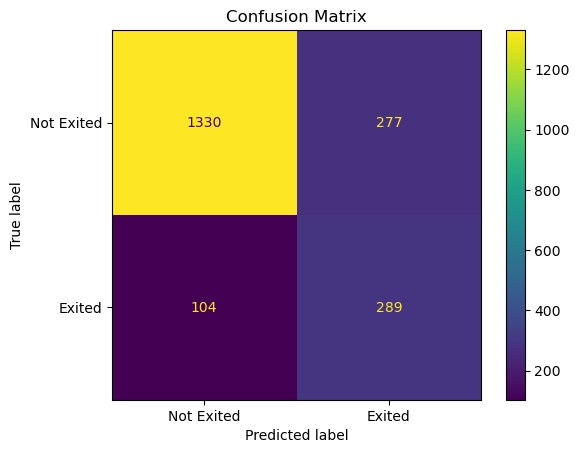

In [41]:
# Generate predictions
y_pred = (model.predict(X_test) > 0.5).astype(int).flatten()

# Display the confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=["Not Exited", "Exited"])
plt.title("Confusion Matrix")
plt.show() 